# A Hybrid Learning Approach to Synthetic Position Construction for Tax Loss Harvesting

# Generation of Synthetic Positions Using Hybrid Learning

In [571]:
import pickle
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
import statsmodels.api as sm


corr_matrix_file_path = "pickles/corr_matrix.obj"
x_labels_file_path = "pickles/X_labels.obj"
sptm_comp_file_path = "pickles/sptm_composition.obj"
sptm_price_file_path = "pickles/sptm_price.obj"

In [626]:
# Composition data from pickle
sptm_comp_file = open(sptm_comp_file_path, 'rb')
sptm_composition = pickle.load(sptm_comp_file)
sptm_comp_file.close()

# Price history downloaded from Yahoo Finance and stored in pickle
sptm_price_file = open(sptm_price_file_path, 'rb')
sptm_price_history = pickle.load(sptm_price_file)
sptm_price_file.close()

all_tickers = sptm_composition.keys()

# Gets a list of all valid trading dates
all_dates = sptm_price_history[list(all_tickers)[0]].axes[0].values
dates = pd.DatetimeIndex(data=all_dates)
current_date = all_dates[0]

# 80/20 Test/Train Split
# Data Range: 2015-01-02 - 2020-08-10
# Testing Range: 2020-08-11 - 2021-12-31
train_start_date = 0
train_end_date= 1410
test_start_date = 1411
test_end_date = 1762

### Finding Highly Correlated Stocks
#### Use the *do_corr_matrix_regen* variable to tell the code to generate the correlation matrix, else it will load it from a pickle

In [642]:
do_corr_matrix_regen = False

In [643]:
num_stocks = len(all_tickers)


def regenerate_corr_matrix(end_date, recent_days):
    """Calculates the correlation between every stock's percent time series
    :param end_date: The last date for which data should be used to generate the correlation matrix
    :param recent_days: How many days of price history should be used to calculate the correlation matrix
    """
    x_vars = []
    x_labels = []

    for ticker in all_tickers:
        x_vars.append(sptm_price_history[ticker].Close.pct_change().iloc[end_date-recent_days:end_date])
        x_labels.append(ticker)

    correlation_matrix = [[0 for _ in range(0, num_stocks)] for _ in range(0, num_stocks)]

    for l in range(0, num_stocks):
        for m in range(0, num_stocks):
            correlation_matrix[l][m] = x_vars[l].corr(x_vars[m])
    correlation_matrix = pd.DataFrame(correlation_matrix, columns=x_labels[0:num_stocks])

    correlation_matrix_file = open(corr_matrix_file_path, 'wb')
    pickle.dump(correlation_matrix, correlation_matrix_file)
    correlation_matrix_file.close()

    x_labels_file = open(x_labels_file_path, 'wb')
    pickle.dump(x_labels, x_labels_file)
    x_labels_file.close()


def load_corr_matrix():
    """Loads correlation matrix and labels from pickles
    :returns: [correlation_matrix, x_labels]
    """
    # Covariance Matrix from pickle
    corr_matrix_file = open(corr_matrix_file_path, 'rb')
    correlation_matrix = pickle.load(corr_matrix_file)
    corr_matrix_file.close()

    # X_Labels from pickle
    x_labels_file = open(x_labels_file_path, 'rb')
    x_labels = pickle.load(x_labels_file)
    x_labels_file.close()

    return correlation_matrix, x_labels


if do_corr_matrix_regen:
    regenerate_corr_matrix(train_end_date-500, recent_days=60)

corr_matrix, X_labels = load_corr_matrix()

In [648]:
def filter_substantially_similar_securities(ticker, series, additional_stocks=None):
    """Filters out the stocks you cannot buy because of a wash sale
    :param series: The series of correlated stocks that should be filtered
    :param ticker: Ticker to filter out securities for
    :param additional_stocks: Any additional stocks you want to filter out (default = None)
    """
    if additional_stocks is None:
        additional_stocks = []

    # Handles Google having both GOOG and GOOGL in the dataset
    if ticker == "GOOG" or ticker:
        additional_stocks.append("GOOG")
        additional_stocks.append("GOOGL")

    additional_stocks.append(ticker)

    return series.drop(additional_stocks)


def find_top_correlated_stocks(ticker, n):
    """Finds the top n stocks correlated with a given stock
    :param n: the number of correlated stocks to return
    :param ticker: The ticker for which correlated stocks should be found
    :returns: A list (sorted by most correlation) of correlated stocks
    """
    index = X_labels.index(ticker)

    correlated_stocks = corr_matrix.iloc[index].sort_values(ascending=False)
    filtered_correlations = filter_substantially_similar_securities(ticker, correlated_stocks)

    return filtered_correlations.iloc[:n]

### Principle Component Analysis

In [651]:
def get_price_histories_dataframe(stocks, target_stock, end_date, recent_days):
    """Compiles a DataFrame with the price histories of the specified stocks
    :param target_stock: The stock for which the dataset should be created
    :param stocks: The stocks to include in the DataFrame
    :param end_date: The last date for which data should be used to get the price history
    :param recent_days: How many days of price history should be fetched
    :returns: (Features DataFrame, Target DataFrame)"""
    d = {}
    for correlated_stock in stocks:
        d[correlated_stock] = sptm_price_history[correlated_stock].Close.values[end_date-recent_days:end_date]
    target = pd.DataFrame({target_stock: sptm_price_history[target_stock].Close.values[end_date-recent_days:end_date]})
    return pd.DataFrame(data = d), target

def get_datasets(target_stock, n, end_date, recent_days):
    """Compiles the necessary datasets for PCA. One with the price history of the features, and one with the price history of the target
    :param target_stock: The stock for which the dataset should be created
    :param n: the number of datasets to get
    :param end_date: The last date for which data should be used to get the price history
    :param recent_days: How many days of price history should be fetched
    :returns: (x, y) where x and y are DataFrames
    """
    corr_stocks = find_top_correlated_stocks(target_stock, n).keys().values
    return get_price_histories_dataframe(corr_stocks,target_stock, end_date, recent_days)

x,y = get_datasets('AAPL', 10, train_end_date, 60)

In [573]:
# Standardize the features
X = StandardScaler().fit_transform(x)

In [580]:
number_components = 2
pca = SparsePCA(n_components=number_components) # TODO validate this
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns=["PC "+ str(i) for i in range (0, number_components)])
finalDf = pd.concat([principalDf, y], axis = 1)
model = sm.OLS(principalDf, y).fit()
print(model.params)

loadings = pd.DataFrame(pca.components_.T, index=x.columns)
# print(loadings)
#print(pca.explained_variance_ratio_)
#print(pca.singular_values_)
#print(model.pvalues)

loadings_dict = {}
print()
#print(loadings[0].index.values)


print("printing all components")
# for pc in range(0, number_components):
#     for c_stock in loadings[pc].index.values:
#         synthetic_position[c_stock]= loadings[pc][c_stock]
#     print(synthetic_position)
#     print()
#     synthetic_position={}

loadings_dict={stock: [] for stock in loadings[0].index.values}

for c_stock in loadings[0].index.values:
    for pc in range(0, number_components):
        loadings_dict[c_stock].append(loadings[pc][c_stock])
print(loadings_dict)
print()

synthetic_position = {}
for c_stock in loadings_dict.keys():
    quantity = 0
    for pc in range(0, number_components):
        quantity += model.params[pc]['AAPL']*loadings_dict[c_stock][pc]
    synthetic_position[c_stock] = quantity


print(synthetic_position)


             0         1
AAPL  0.018607  0.008323

printing all components
{'LRCX': [0.32443655157139994, 0.1928006431122659], 'TXN': [0.4096399108172963, 0.0], 'FORM': [0.3695641692300739, 0.07530027071038661], 'RMBS': [0.0, 0.7458539743320353], 'CRUS': [0.2820752455787747, 0.1711237650695028], 'ACLS': [0.25846432169490835, 0.2730462394031352], 'NXPI': [0.15965038167885812, 0.4981985818276537], 'MSFT': [0.40454046193568216, 0.0], 'TRMB': [0.30335769015741765, 0.22007730665401326], 'AVGO': [0.40351087301685185, 0.019651731644320963]}

{'LRCX': 0.007641597758057534, 'TXN': 0.007622302879184898, 'FORM': 0.007503333169286232, 'RMBS': 0.006207826603823433, 'CRUS': 0.0066729480811757134, 'ACLS': 0.0070819241805018, 'NXPI': 0.007117229397859462, 'MSFT': 0.0075274157774495405, 'TRMB': 0.0074764032786528295, 'AVGO': 0.007671821457065169}


In [ ]:
def hybrid_learning_replace(ticker) -> {}:
    """Determines which stocks to buy to emulate the performance of another
    :param ticker: The stock for which a synthetic position should be calculated
    :returns: Dictionary of replacement tickers and their quantities
    """
    print(ticker)
    return {}
    #TODO

# Stock Market Backtester

If you want to run this simulator with different stocks and/or generate a new starting portfolio, do the following:
1. Create a CSV file with the format: Ticker, Quantity
2. Run **csvToComp.py** to generate text you can paste in as the *snp_composition* variable in **compToPickle.py**
3. Run **compToPickle.py**
4. Adjust the date range in **yfToPickle.py**
5. Run **yfToPickle.py**, which will take a while, since it is downloading all of the price histories from Yahoo Finance

In [802]:
import pandas as pd
import pyfolio as pf  #install using  pip3 install git+https://github.com/quantopian/pyfolio
from enum import Enum
import warnings
import pickle
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

snp_comp_file_path = "pickles/snp_composition.obj"
snp_price_file_path = "pickles/snp_price.obj"

In [803]:
# Composition data from pickle
snp_comp_file = open(snp_comp_file_path, 'rb')
snp_composition = pickle.load(snp_comp_file)
snp_comp_file.close()

# Price history downloaded from Yahoo Finance and stored in pickle
snp_price_file = open(sptm_price_file_path, 'rb')
price_history = pickle.load(snp_price_file)
snp_price_file.close()

all_tickers = snp_composition.keys()

# Gets a list of all valid trading dates
all_dates = price_history[list(all_tickers)[0]].axes[0].values
dates = pd.DatetimeIndex(data=all_dates)
current_date = all_dates[0]

In [804]:
def get_stock_price(ticker, day, time) -> float:
    """Retrieves the closing price of a stock on a given date
    :param ticker: stock for which to retrieve the value
    :param day: date on which to retrieve the value
    :param time of day to calculate the value, either Time.OPEN or Time.CLOSE
    """
    if time == Time.OPEN:
        return round(price_history[ticker].Open[day], 2)
    elif time == Time.CLOSE:
        return round(price_history[ticker].Close[day], 2)


class Time(Enum):
    OPEN = 0
    CLOSE = 1


class Stock:
    def __init__(self, ticker, q=0):
        """Creates an object representing an owned stock
        :param ticker: The stock's ticker symbol
        :param q: How much of this stock is owned (this should only be used when constructing initial stock portfolios, as it essentially creates stock for free)
        """
        self.ticker = ticker
        self.quantity = q
        self.avg_cost = get_stock_price(self.ticker, current_date, Time.CLOSE)

    def buy(self, quantity, day_price):
        """Simulates a portfolio acquiring new stock
        :param quantity: The amount of new stock to acquire
        :param day_price: The price of the stock on the day of acquisition
        """
        previously_owned = self.quantity
        self.quantity += quantity
        self.avg_cost += (previously_owned * self.avg_cost + quantity * day_price) / self.quantity

    def sell(self, q, day_price):
        """Simulates a portfolio selling a stock
        :param q: The amount of new stock to sell
        :param day_price: The price of the stock on the day of acquisition
        """
        previously_owned = self.quantity
        self.quantity -= q
        self.avg_cost -= (previously_owned * self.avg_cost - q * day_price) / self.quantity

    def sell_all(self):
        """Simulates selling all of a stock
        """
        self.quantity = 0
        self.avg_cost = 0

    def get_pct_change(self):
        """Gets the percent change of the stock based on the average cost
        """
        change = self.get_change()
        return 100 * (change / self.avg_cost)

    def get_change(self) -> float:
        """Gets the difference between the stock's average purchase price and its current price
        :returns: float
        """
        current_price = get_stock_price(self.ticker, current_date, Time.CLOSE)
        return current_price - self.avg_cost


class Portfolio:
    def __init__(self, name, starting_cash_balance: float = 1000000, starting_stocks=None, baseline = False, synthetic = False):
        """Creates a new portfolio
        :param starting_cash_balance: The amount of cash the portfolio should start with (default 100,000.0)
        :param starting_stocks: A dictionary containing the stocks the portfolio should begin with {'Ticker': Stock Object} (default is no starting stocks)
        """
        self.name = name
        if starting_stocks is None:
            starting_stocks = {}
        self.stocks = starting_stocks
        self.cash_balance = starting_cash_balance
        self.value = 0
        self.calculate_value(Time.CLOSE)
        self.price_history = {}
        self.closing_prices = []
        self.returns = None
        self.wash_sale_list = {}
        self.baseline = baseline
        self.synthetic = synthetic
        self.diff = []

    def calculate_value(self, time):
        """Calculates the value of the portfolio based on the close of the global current date
        :param time of day to calculate the value, either Time.OPEN or Time.CLOSE
        """
        self.calculate_value_date(current_date, time)

    def calculate_value_date(self, c_day, time=Time.CLOSE):
        """Calculates the value of the portfolio based on a specified date
        :param c_day: the date on which the portfolio's value should be calculated
        :param time of day to calculate the value, either Time.OPEN or (default) Time.CLOSE
        """

        self.value = self.cash_balance
        for stock in self.stocks.keys():
            self.value += get_stock_price(stock, c_day, time) * self.stocks[stock].quantity

        return self.value

    def update_wash_sale_list(self):
        """Increments the counter for every item in the wash sale list and removes an item if the counter is >30
        """
        remove_from_list = []
        for wash_stock in self.wash_sale_list.keys():
            self.wash_sale_list[wash_stock] += 1
            if self.wash_sale_list[wash_stock] > 30:
                remove_from_list.append(wash_stock)

        for to_remove in remove_from_list:
            self.wash_sale_list.pop(to_remove)

    def begin_day(self):
        """Calculates the starting value of the day and updates the wash sale list
        """
        self.calculate_value(Time.CLOSE)
        self.update_wash_sale_list()

    def end_day(self, date_to_record):
        """"Calculates the day's closing value and adds it to a list
        :param date_to_record: The date associated with the ending day
        """
        self.calculate_value(Time.CLOSE)
        self.price_history[date_to_record] = self.value
        self.closing_prices.append(self.value)

    def end_simulation(self, start_date_index, end_date_index):
        """Creates a Pandas Series of percent change of closing values and returns it
        :param start_date_index: The index of the day that the simulation started
        :param end_date_index: The index of the day that the simulation ended
        """
        self.returns = pd.Series(data=self.closing_prices, index=dates[start_date_index:end_date_index]).pct_change() #TODO delete [len(dates)-60:]
        return self.returns

    def does_own_stock(self, ticker) -> bool:
        """Reports whether this portfolio contains a given stock
        :param ticker: The stock to search for
        """
        return ticker in self.stocks.keys()

    def buy_stock(self, ticker, quantity_to_buy):
        """Buys stock using cash balance if possible
        :param ticker: The stock to purchase
        :param quantity_to_buy: The quantity of the stock to purchase (can be a float)
        """
        stock_price = get_stock_price(ticker, current_date, Time.CLOSE)
        trade_basis = stock_price * quantity_to_buy  #TODO can add fees here

        # Exit if we cannot complete the trade
        if trade_basis > self.cash_balance:
            warnings.warn("Not enough cash to execute trade: buy " + str(quantity) + " " + ticker)
            return

        if ticker in self.wash_sale_list:
            warnings.warn("Cannot buy " + ticker + ": wash sale violation")
            return

        # If we do not currently own the stock, create an entry
        if ticker not in self.stocks.keys():
            self.stocks[ticker] = Stock(ticker)

        # Execute the trade
        self.stocks[ticker].buy(quantity, stock_price)
        self.cash_balance -= trade_basis

    def sell_stock(self, ticker, sell_quantity=0, sell_all=False):
        """Sells stock and adds to cash balance
        :param ticker: The stock to sell
        :param sell_quantity: The quantity of the stock to sell (can be a float)
        :param sell_all: Optional parameter to sell all stock
        """
        stock_price = get_stock_price(ticker, current_date, Time.CLOSE)
        # Ensure we have enough stock to sell
        quantity_owned = self.stocks[ticker].sell_quantity
        if sell_quantity > quantity_owned:
            return

        if sell_all or sell_quantity == quantity_owned:
            self.stocks[ticker].sell_all()
            self.cash_balance += quantity_owned * stock_price
            self.stocks.pop(ticker)

            # Update the wash sale list
            self.wash_sale_list[ticker] = 0
            return

        # Do the trade
        self.stocks[ticker].sell()
        self.cash_balance += sell_quantity * stock_price  #TODO maybe things should be added to the wash sale list even if we just sell partial (but in theory we are always doing sellall)

    def identify_losers(self):
        """Identifies stocks that have dropped in value more than 5% since they were bought
        :returns: List of all stocks that have dropped more than 5%
        """
        identified_losers = []
        for owned_stock in self.stocks.keys():
            if self.stocks[owned_stock].get_change() <= -1 * (0.05 * self.value):
                identified_losers.append(owned_stock)
        return identified_losers

    def calculate_diff(self, baseline):
        for m in range(0, len(self.closing_prices)):
            self.diff.append(self.closing_prices[m]-baseline[m])

def get_normalized_portfolios(p, s_s_date):
    """Accepts portfolios and returns new portfolios with the same value on the start date
    Limitations: All portfolios but the synthetic one can only contain one stock
    :param p: The portfolios to normalize (the baseline must be in position 1 and the synthetic portfolio must be marked)
    :param s_s_date: The start date on which to normalize the portfolios
    """
    synth = None
    for port in p:
        if port.synthetic:
            synth = port

    return_ports = []

    for port in p:
        if port==synth:
            continue

        synth_value = synth.calculate_value_date(s_s_date)
        port_value = port.calculate_value_date(s_s_date)
        ratio = synth_value/port_value

        new_stock_ticker = list(port.stocks.keys())[0]

        is_baseline = port.baseline

        new_port = Portfolio(port.name, port.cash_balance, {new_stock_ticker: Stock(new_stock_ticker, ratio)}, baseline=is_baseline)

        return_ports.append(new_port)

    return_ports.append(synth)
    return return_ports

def plot_portfolio(p):
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=round((sim_end_date-sim_start_date)/10)))

    for port in p:
        days = []
        y_price = []
        for price in port.price_history:
            days.append(price)
            y_price.append(port.price_history[price])
        plt.plot(days,y_price, label = port.name)

    plt.gcf().autofmt_xdate()
    plt.rcParams["figure.figsize"] = [16,9]
    plt.legend(loc='best')
    plt.show()

def plot_differences(p):
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=round((sim_end_date-sim_start_date)/10)))

    for port in p:
        days = []
        for price in port.price_history:
            days.append(price)
        plt.plot(days,port.diff, label = port.name)
    plt.gcf().autofmt_xdate()
    plt.rcParams["figure.figsize"] = [16,9]
    plt.legend(loc='best')
    plt.show()

def get_correlations():
    for p in portfolios:
        if p.baseline:
            for po in portfolios:
                print(po.name + " correlation with " + p.name+": "+str(po.returns.corr(p.returns))) if not po.baseline else ""
            return


def generate_end_report():
    plot_portfolio(portfolios)
    for p in portfolios:
        p.calculate_diff(portfolios[0].closing_prices)
    plot_differences(portfolios)
    get_correlations()

In [805]:
def model_output_to_portfolio(model_output):
    p = {}
    for a_stock in model_output.keys():
        p[a_stock] = Stock(a_stock, model_output[a_stock])
    return p

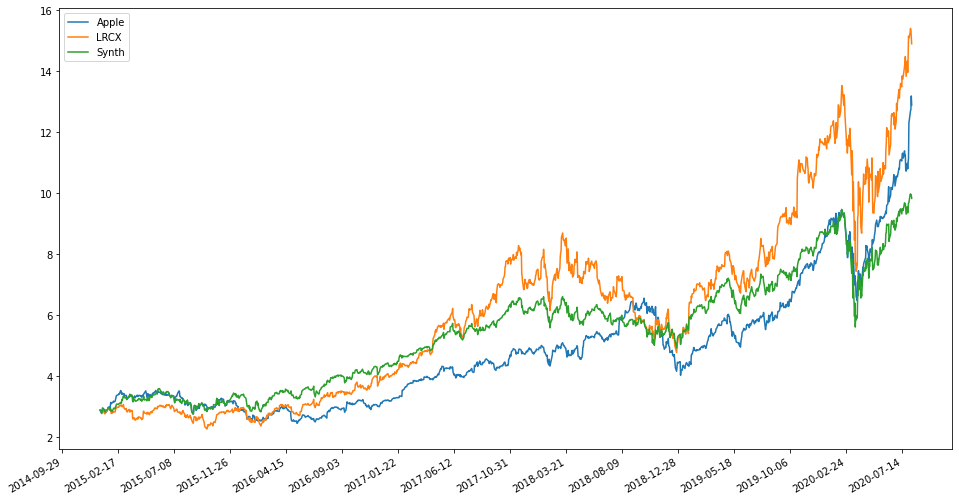

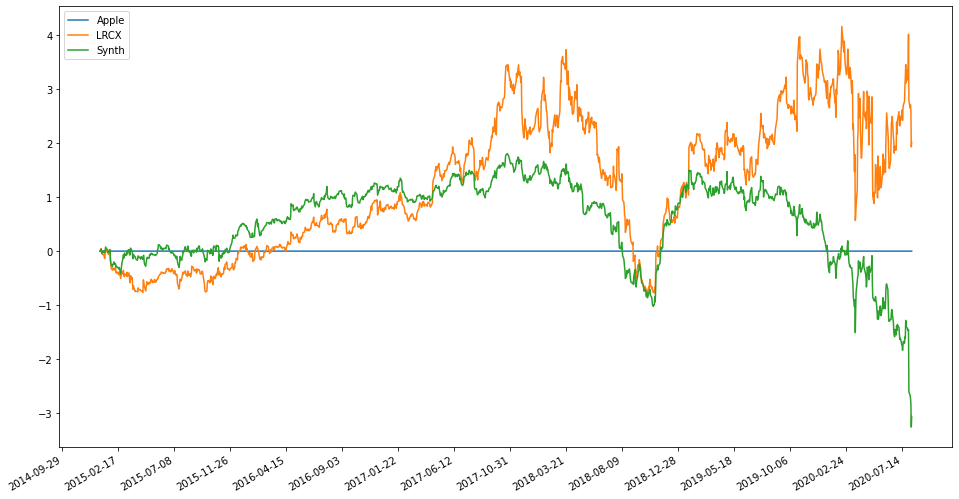

LRCX correlation with Apple: 0.5824195632737528
Synth correlation with Apple: 0.703346247873006


In [808]:
# Set simulator start and end dates
sim_start_date = train_start_date
sim_end_date = train_end_date

# The portfolios in this simulation
synth_apple = model_output_to_portfolio({'LRCX': 0.007641597758057534, 'TXN': 0.007622302879184898, 'FORM': 0.007503333169286232, 'RMBS': 0.006207826603823433, 'CRUS': 0.0066729480811757134, 'ACLS': 0.0070819241805018, 'NXPI': 0.007117229397859462, 'MSFT': 0.0075274157774495405, 'TRMB': 0.0074764032786528295, 'AVGO': 0.007671821457065169})

h_l_portfolio = Portfolio("Synth", 0, synth_apple, synthetic = True)
aapl_portfolio = Portfolio("Apple", 0, {'AAPL': Stock('AAPL', 1)}, baseline=True)
lrcx_port = Portfolio("LRCX", 0, {'LRCX': Stock('LRCX', 1)})

# ensure that the real stock is first in the portfolio
portfolios = get_normalized_portfolios([aapl_portfolio, h_l_portfolio, lrcx_port], sim_start_date)

# Run the simulation
for date in range(sim_start_date, sim_end_date):
    # update the current day
    current_date = date

    # Allow the portfolio to perform start of day updates
    for sim_portfolio in portfolios:
        sim_portfolio.begin_day()

        # Determine which stocks should be tax loss harvested
        losers = sim_portfolio.identify_losers()

        # for losing_stock in losers:
        #     # Get dictionary of replacement stocks {'Ticker': Quantity}
        #     replacement_stocks = hybrid_learning_replace(losing_stock)
        #
        #     # Sell the losing stock
        #     portfolio.sell_stock(losing_stock, sell_all=True)
        #
        #     # Buy the replacement stocks
        #     for buy_stock in replacement_stocks.keys():
        #         portfolio.buy_stock(buy_stock, replacement_stocks[buy_stock])

        # Allow the portfolio to perform end-of-day updates
        sim_portfolio.end_day(all_dates[date])

returns = []

# Inform the portfolio that the simulation has ended
for portfolio in portfolios:
    returns.append(portfolio.end_simulation(sim_start_date, sim_end_date))

generate_end_report()

In [807]:
#pf.create_returns_tear_sheet(returns)